## Predição

In [1]:
from rubianets import *

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [262]:
# gerando uma série

time = np.arange(4 * 365 , dtype="float32")

baseline = 10
amplitude = 40
slope = 0.05
noise_level = 3

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

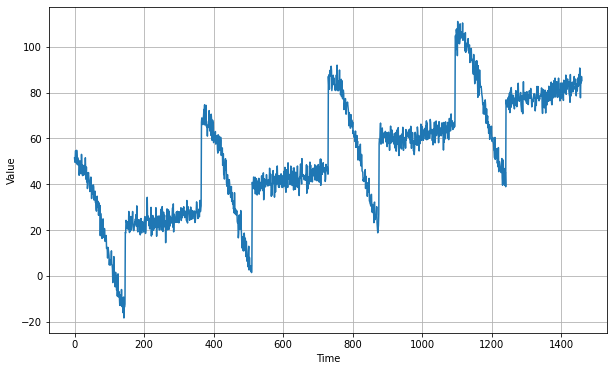

In [263]:
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Preparando o Dataset
* O dataset de treino recebe o seguinte formato: 
    * itens no dataset
    * número de itens em cada série
    * número de features em cada série (univariada ou multivariada)

In [21]:
print(series.shape)
s2 = series.reshape(365, 4)

target = s2[:, -1] # última coluna
dataset = s2[:, :-1] # tudo menos última coluna
dataset = dataset.reshape(365, 3, 1)
print(target.shape)
print(dataset.shape)

(1460,)
(365,)
(365, 3, 1)


## MLP

In [22]:
dataset2 = dataset.reshape(365, 3)

model = Sequential()
model.add(Dense(10, input_dim=(dataset2.shape[1]), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

history = model.fit(dataset2, target, epochs=50, batch_size=4, verbose=0, validation_split=0.20)

# histórico de dados de 4 anos, usando cada ano como 1 feature, vamos prever o ano 4 usando os 3 anos anteriores

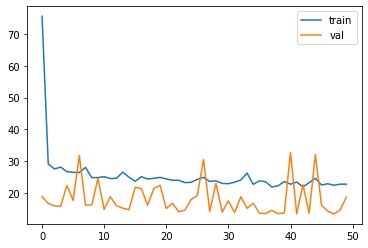

RMSE: 4.808


In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

yhat = model.predict(dataset2)
rmse = np.sqrt(mean_squared_error(yhat, target))
print('RMSE: %.3f' % rmse)

## RNN

In [26]:
model = Sequential()
model.add(SimpleRNN(128, input_shape=(dataset.shape[1], dataset.shape[2]), activation='relu'))
# lembrando que a unidade RNN recebe dados no formato Batch_size x Timesteps x Features
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])

history = model.fit(dataset, target, epochs=50, batch_size=4, verbose=0, validation_split=0.20)

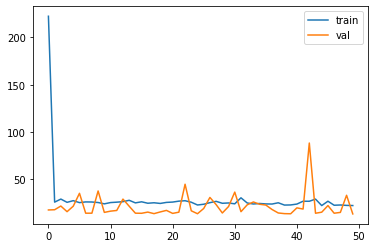

RMSE: 4.289


In [27]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

yhat = model.predict(dataset)
rmse = np.sqrt(mean_squared_error(yhat, target))
print('RMSE: %.3f' % rmse)

## Return_sequences=True 
* Permite empilhar camadas RNN

In [28]:
model = Sequential()
model.add(SimpleRNN(128, input_shape = (dataset.shape[1], dataset.shape[2]), activation='relu', return_sequences=True))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])

history = model.fit(dataset, target, epochs=50, batch_size=4, verbose=0, validation_split=0.20)

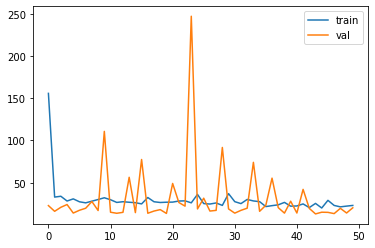

RMSE: 4.483


In [29]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

yhat = model.predict(dataset)
rmse = np.sqrt(mean_squared_error(yhat, target))
print('RMSE: %.3f' % rmse)

In [30]:
model = Sequential()
model.add(LSTM(128, input_shape=(dataset.shape[1], dataset.shape[2]), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mse'])

history = model.fit(dataset, target, epochs=50, batch_size=4, verbose=0, validation_split=0.20)

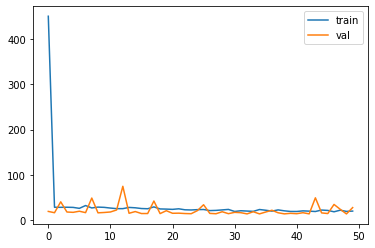

RMSE: 4.846


In [31]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

yhat = model.predict(dataset)
rmse = np.sqrt(mean_squared_error(yhat, target))
print('RMSE: %.3f' % rmse)

## Exemplo com LSTM

* pool2.csv : Previsão da poluição do ar

* Conjunto de dados que relata o clima e o nível de poluição a cada hora durante cinco anos na embaixada dos EUA em Pequim, China.

* pm2.5: concentração de PM2.5
* DEWP: ponto de Orvalho
* TEMP: temperatura
* PRES: pressão
* cbwd: direção combinada do vento
* Iws: velocidade acumulada do vento
* Is: horas acumuladas de neve
* Ir: horas acumuladas de chuva

In [50]:
dataset = pd.read_csv('dataset/poll2.csv', header=0, index_col=0)
dataset.info()
print(dataset.shape)
dataset

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB
(43800, 8)


,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [51]:
encoder = LabelEncoder()
dataset.wnd_dir = encoder.fit_transform(dataset.wnd_dir)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  int64  
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 3.0+ MB


## Dataset com mais de uma informação por step temporal

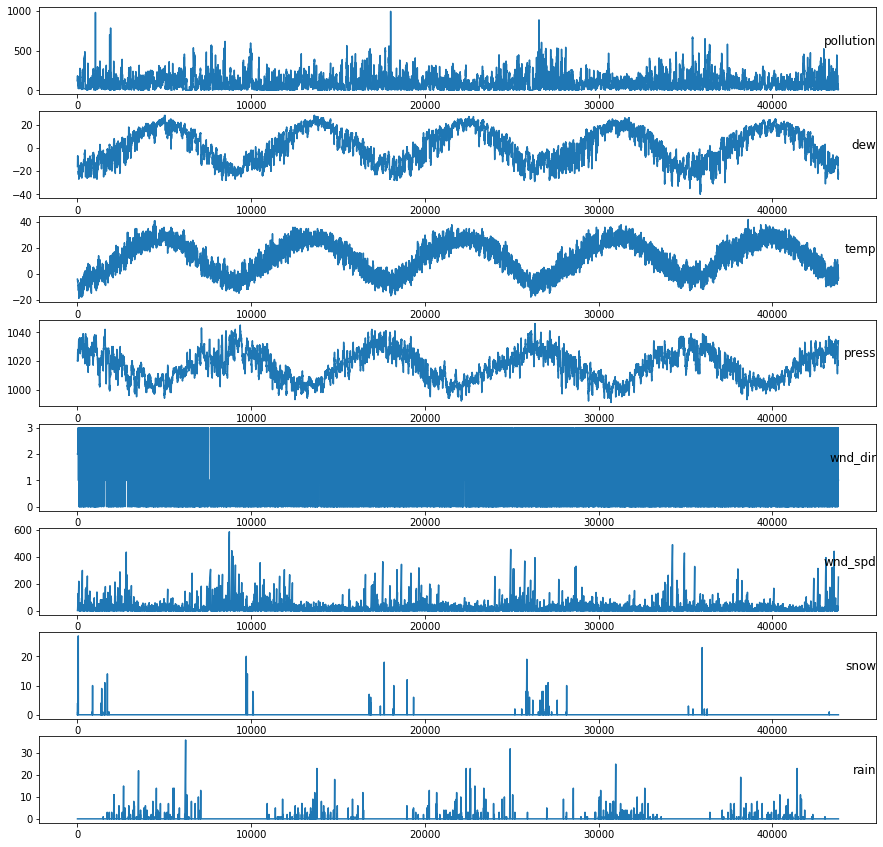

In [52]:
plt.figure(figsize=(15,15))
for i, col in enumerate(dataset.columns):
    plt.subplot(len(dataset.columns), 1, i+1)
    plt.plot(dataset[col].values)
    plt.title(col, y=0.5, loc='right')
plt.show()

## Preparação dos dados
Reorganizar os dados do formato série para o formato de aprendizado supervisionado em timesteps

In [209]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True): # data deve ser um pandas dataframe
    n_vars = data.shape[1]
    print('\nColunas no dataset:', n_vars)
    
    df = data.copy()
    cols_name = df.columns
    
    cols, namesp = list(), list()    
    # criando os intervalos anteriores do passado (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        namesp += [('%s(t-%d)' % (cols_name[j], i)) for j in range(n_vars)]
    aggp = pd.concat(cols, axis=1)
    aggp.columns = namesp
    aggp = aggp[namesp]
    
    cols, namesn = list(), list()    
    # criando os intervalos posteriores do futuro (t+1, ...t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            namesn += [('%s(t)' % (cols_name[j])) for j in range(n_vars)]
        else:
            namesn += [('%s(t+%d)' % (cols_name[j], i)) for j in range(n_vars)]            
    aggn = pd.concat(cols, axis=1)
    aggn.columns = namesn
    aggn = aggn[namesn]
    
    agg = pd.concat([aggp, aggn], axis=1) # vamos agregar antes de dropar valores nulos e retornar separados
    
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg[namesp], agg[namesn]

In [210]:
dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_norm = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns, index=dataset.index)
print(dataset_norm.head())

# cria coluna no tempo para previsão supervisionada
#   1 passo para o passado, 1 passo futuro (equivale ao tempo atual t)
data_previous, data_next = series_to_supervised(dataset_norm, 1, 1)
print('\nShape da série previous:', data_previous.shape)
print(data_previous.head())

print('\nShape da série next:', data_next.shape)
print(data_next.head())

# separação da base de treino e teste
X = data_previous.values
y = data_next['pollution(t)'].values # vamos fazer a previsão de pollution, que é a primeira coluna 

print('\nVariáveis preditoras:')
print(X[:5])
 
print('\nVariável dependente:')
print(y[:5])

                     pollution       dew      temp     press   wnd_dir  \
date                                                                     
2010-01-02 00:00:00   0.129779  0.352941  0.245902  0.527273  0.666667   
2010-01-02 01:00:00   0.148893  0.367647  0.245902  0.527273  0.666667   
2010-01-02 02:00:00   0.159960  0.426471  0.229508  0.545454  0.666667   
2010-01-02 03:00:00   0.182093  0.485294  0.229508  0.563637  0.666667   
2010-01-02 04:00:00   0.138833  0.485294  0.229508  0.563637  0.666667   

                      wnd_spd      snow  rain  
date                                           
2010-01-02 00:00:00  0.002290  0.000000   0.0  
2010-01-02 01:00:00  0.003811  0.000000   0.0  
2010-01-02 02:00:00  0.005332  0.000000   0.0  
2010-01-02 03:00:00  0.008391  0.037037   0.0  
2010-01-02 04:00:00  0.009912  0.074074   0.0  

Colunas no dataset: 8

Shape da série previous: (43799, 8)
                     pollution(t-1)  dew(t-1)  temp(t-1)  press(t-1)  \
date         

In [211]:
n_train_hours = 4 * 365 * 24

X_train = X[:n_train_hours, :]
X_test = X[n_train_hours:, :]

y_train = y[:n_train_hours]
y_test = y[n_train_hours:]

print('Train | Test Split Shape:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# reshape para 3D [samples, timesteps, features] - formato requerido RNN
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print('Train | Test Split Shape:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Train | Test Split Shape: (35040, 8) (35040,) (8759, 8) (8759,)
Train | Test Split Shape: (35040, 1, 8) (35040,) (8759, 1, 8) (8759,)


In [212]:
def evaluate_model(model, epochs, X_train, y_train, X_test, y_test):

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.1, verbose=0, shuffle=True)
    loss = model.evaluate(X_test, y_test, verbose=0)

    plt.figure(figsize=(15,6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Evolução do MAE')

    y_hat = model.predict(X_test).flatten()

    plt.subplot(1, 2, 2)
    plt.plot(y_test, y_hat, 'o')
    plt.title('Predito vs Observado')
    plt.xlabel('Valor Verdadeiro')
    plt.ylabel('Valor Predito')
    plt.show()   
    
    print('MAE no dataset de teste: %.3f' % loss)

    rmse = np.sqrt(mean_squared_error(y_test, y_hat))
    print('RMSE: %.3f' % rmse)

## Rede Neural MLP

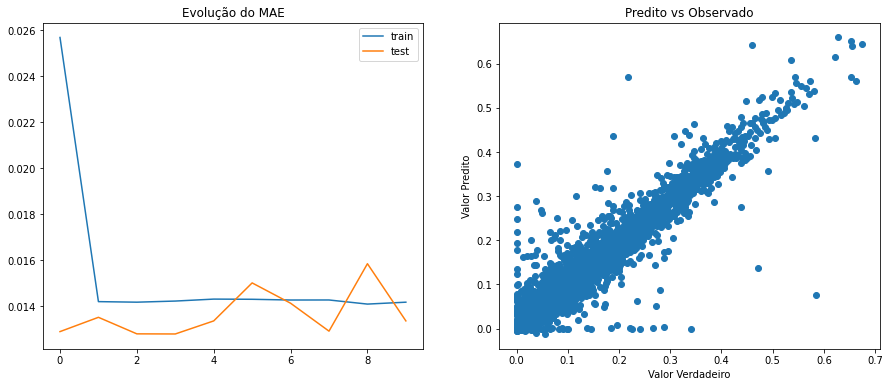

MAE no dataset de teste: 0.013
RMSE: 0.025


In [213]:
model = Sequential()
model.add(Dense(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

evaluate_model(model, 10, X_train, y_train, X_test, y_test)

## Rede Neural LSTM

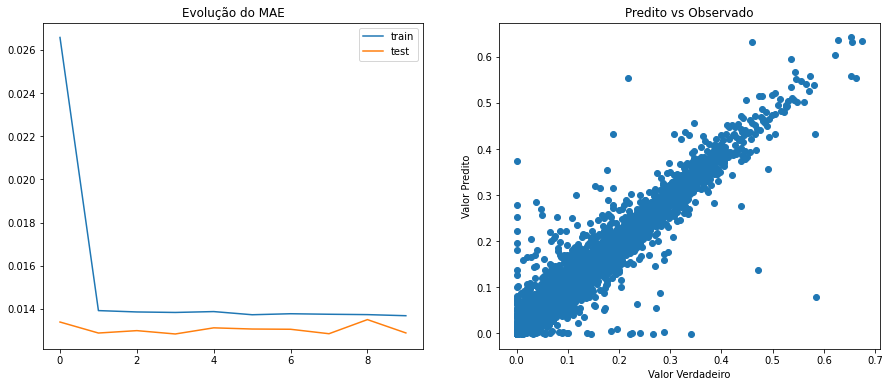

MAE no dataset de teste: 0.012
RMSE: 0.024


In [214]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

evaluate_model(model, 10, X_train, y_train, X_test, y_test)

## Série temporal com mais de um item por série

In [220]:
steps = 24
features = dataset.shape[1]
print('Avaliando %d features para janelas com %d timesteps\n' % (features, steps))

dataset = dataset.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
dataset_norm = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns, index=dataset.index)
print(dataset_norm.head())

# cria coluna no tempo para previsão supervisionada
#   3 passos para o passado, 1 passo futuro (equivale ao tempo atual t)
data_previous, data_next = series_to_supervised(dataset_norm, steps, 1)
print('\nShape da série previous:', data_previous.shape)
print(data_previous.head())

print('\nShape da série next:', data_next.shape)
print(data_next.head())

# separação da base de treino e teste
X = data_previous.values
y = data_next['pollution(t)'].values # vamos fazer a previsão de pollution, que é a primeira coluna 

print('\nVariáveis preditoras:')
print(X[:5])
 
print('\nVariável dependente:')
print(y[:5])

Avaliando 8 features para janelas com 24 timesteps

                     pollution       dew      temp     press   wnd_dir  \
date                                                                     
2010-01-02 00:00:00   0.129779  0.352941  0.245902  0.527273  0.666667   
2010-01-02 01:00:00   0.148893  0.367647  0.245902  0.527273  0.666667   
2010-01-02 02:00:00   0.159960  0.426471  0.229508  0.545454  0.666667   
2010-01-02 03:00:00   0.182093  0.485294  0.229508  0.563637  0.666667   
2010-01-02 04:00:00   0.138833  0.485294  0.229508  0.563637  0.666667   

                      wnd_spd      snow  rain  
date                                           
2010-01-02 00:00:00  0.002290  0.000000   0.0  
2010-01-02 01:00:00  0.003811  0.000000   0.0  
2010-01-02 02:00:00  0.005332  0.000000   0.0  
2010-01-02 03:00:00  0.008391  0.037037   0.0  
2010-01-02 04:00:00  0.009912  0.074074   0.0  

Colunas no dataset: 8

Shape da série previous: (43776, 192)
                     pollution(

In [221]:
n_train_hours = 4 * 365 * 24

X_train = X[:n_train_hours, :]
X_test = X[n_train_hours:, :]

y_train = y[:n_train_hours]
y_test = y[n_train_hours:]

print('Train | Test Split Shape:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# reshape para 3D [samples, timesteps, features] - formato requerido RNN
X_train = X_train.reshape((X_train.shape[0], steps, features))
X_test = X_test.reshape((X_test.shape[0], steps, features))

print('Train | Test Split Shape:', X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X_train[0]

Train | Test Split Shape: (35040, 192) (35040,) (8736, 192) (8736,)
Train | Test Split Shape: (35040, 24, 8) (35040,) (8736, 24, 8) (8736,)


array([[0.12977867, 0.35294122, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00229001, 0.        , 0.        ],
       [0.14889336, 0.36764708, 0.24590163, 0.5272732 , 0.6666667 ,
        0.00381099, 0.        , 0.        ],
       [0.15995975, 0.4264706 , 0.22950819, 0.545454  , 0.6666667 ,
        0.00533197, 0.        , 0.        ],
       [0.18209255, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00839101, 0.03703704, 0.        ],
       [0.13883299, 0.48529413, 0.22950819, 0.5636368 , 0.6666667 ,
        0.00991199, 0.07407407, 0.        ],
       [0.10965794, 0.48529413, 0.21311474, 0.5636368 , 0.6666667 ,
        0.01143297, 0.11111111, 0.        ],
       [0.1056338 , 0.48529413, 0.21311474, 0.5818176 , 0.6666667 ,
        0.01449201, 0.14814815, 0.        ],
       [0.12474848, 0.48529413, 0.22950819, 0.6000004 , 0.6666667 ,
        0.01755106, 0.        , 0.        ],
       [0.12072434, 0.47058827, 0.21311474, 0.6000004 , 0.6666667 ,
        0.0206101 , 0.      

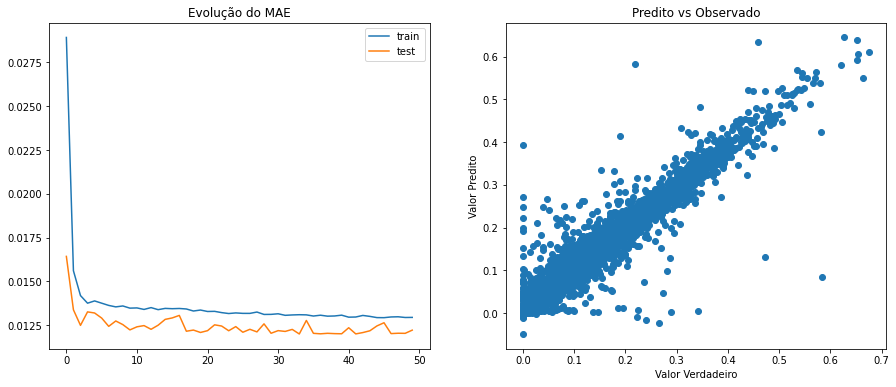

MAE no dataset de teste: 0.012
RMSE: 0.024


In [222]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

evaluate_model(model, 50, X_train, y_train, X_test, y_test)

# Trabalhando com datasets grandes

## from_tensor_slices
* Método para ler o dataset obtendo apenas os elementos a serem usados no processamento de cada época
* O dataset completo não precisa ser carregado na memória

In [25]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.7, np.cos(season_time * 1 * np.pi), 1 / np.exp(2 * season_time))

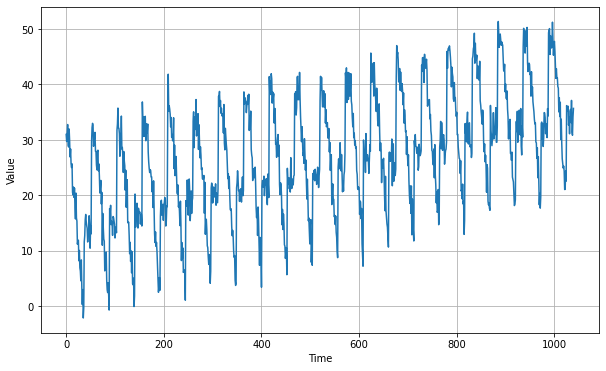

In [47]:
# gerando uma série

timer = np.arange(20*52 , dtype="float32")

baseline = 10
amplitude = 20
slope = 0.02
noise_level = 2

series = baseline + trend(timer, slope) + seasonality(timer, period=52, amplitude=amplitude)
series += noise(timer, noise_level, seed=42)

split_time = 1000
time_train = timer[:split_time]
x_train = series[:split_time]
time_valid = timer[split_time:]
x_valid = series[split_time:]

plt.figure(figsize=(10, 6))
plot_series(timer, series)
plt.show()

In [48]:
print(series[:20])
type(x_train)

[30.99343  29.706982 31.189554 32.778458 29.030529 28.726145 31.97875
 29.912865 26.93017  28.380745 25.73284  25.03221  25.69414  20.575575
 20.092617 21.509802 19.655632 21.31525  17.838413 15.763649]


numpy.ndarray

## Usando from_tensor_slices
* Separando apenas 20 elementos e criando um objeto para ler a partir de um array numpy
* Esse processo evita ter que gerar todas as sequências (timesteps) para alimentar na RNN
    * Ao invés disto, gera pequenos lotes aleatórios de sequências a cada iteração

In [49]:
X_train = series[:20]
dataset1 = tf.data.Dataset.from_tensor_slices(X_train)

* Iterador pelos elementos do objeto from_tensor_slices()

In [50]:
for element in dataset1.as_numpy_iterator(): 
    print(element)

30.99343
29.706982
31.189554
32.778458
29.030529
28.726145
31.97875
29.912865
26.93017
28.380745
25.73284
25.03221
25.69414
20.575575
20.092617
21.509802
19.655632
21.31525
17.838413
15.763649


## Explorando diferentes parâmetros do objeto Dataset (from_tensor_slices)
* Window: obtem intervalos de dados de tamanho definido do dataset completo
* Parâmetro shift: indica quantos elementos devem ser avançados a série completa para obter uma nova janela
* Parâmetro drop_remainder: indica que quando a quantidade de dados for inferior ao tamanho da janela pré-definida, essa última parte pode ser descartada ou utilizada em tamanho menor
    * isso influencia na definição da entrada do algoritmo de predição
    * caso o algoritmo não permita utilizar um tamanho variável, será necessário atribuir true a esse parâmetro
    
* Mapeia map_func nesse conjunto de dados e nivela o resultado

* Use flat_map se quiser garantir que a ordem do seu conjunto de dados permaneça a mesma. Por exemplo, para nivelar um conjunto de dados de lotes em um conjunto de dados de seus elementos

In [51]:
window_size = 5
shift = 1

# cria um dataset maior a partir de um dataset de uma única sequência
dataset1 = tf.data.Dataset.from_tensor_slices(X_train)

# cria janelas de tamanho fixo na sequência
dataset1 = dataset1.window(window_size, shift=shift, drop_remainder=True)

# transforma em estrutura flat
dataset1 = dataset1.flat_map(lambda window: window.batch(window_size))

for element in dataset1.as_numpy_iterator(): 
    print('Elemento:', element)

Elemento: [30.99343  29.706982 31.189554 32.778458 29.030529]
Elemento: [29.706982 31.189554 32.778458 29.030529 28.726145]
Elemento: [31.189554 32.778458 29.030529 28.726145 31.97875 ]
Elemento: [32.778458 29.030529 28.726145 31.97875  29.912865]
Elemento: [29.030529 28.726145 31.97875  29.912865 26.93017 ]
Elemento: [28.726145 31.97875  29.912865 26.93017  28.380745]
Elemento: [31.97875  29.912865 26.93017  28.380745 25.73284 ]
Elemento: [29.912865 26.93017  28.380745 25.73284  25.03221 ]
Elemento: [26.93017  28.380745 25.73284  25.03221  25.69414 ]
Elemento: [28.380745 25.73284  25.03221  25.69414  20.575575]
Elemento: [25.73284  25.03221  25.69414  20.575575 20.092617]
Elemento: [25.03221  25.69414  20.575575 20.092617 21.509802]
Elemento: [25.69414  20.575575 20.092617 21.509802 19.655632]
Elemento: [20.575575 20.092617 21.509802 19.655632 21.31525 ]
Elemento: [20.092617 21.509802 19.655632 21.31525  17.838413]
Elemento: [21.509802 19.655632 21.31525  17.838413 15.763649]


## Explorando batches e shuffle
* Usando o parâmetro window é possível obter diversas amostras de sub-sequências a partir de uma única sequência
* Opção batch permite obter um conjunto dessas subsequências em cada item do iterador
* A opção shuffle permite que as subsequências obtidas sejam de diferentes partes da sequência completa

In [52]:
shuffle_buffer_size = 10
shuffle_buffer = shuffle_buffer_size

window_size = 5
shift = 1
batch_size = 3

# cria um dataset maior a partir de um dataset de uma única sequência
dataset1 = tf.data.Dataset.from_tensor_slices(X_train)

# cria janelas de tamanho fixo na sequência
dataset1 = dataset1.window(window_size+1, shift=shift, drop_remainder=True)
dataset1 = dataset1.flat_map(lambda window: window.batch(window_size+1))

# altera a ordem dos dados
dataset1 = dataset1.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))

# cria batches
dataset1 = dataset1.batch(batch_size).prefetch(1)

for element in dataset1.as_numpy_iterator(): 
    print('Elemento:', element)
    
print('\nElementos disponíveis:', len(X_train))
print('Graus de liberdade:', len(X_train) - shift - (window_size-1))
print('Tamanho do batch:', batch_size)
print('Número de batches:', (len(X_train) - shift - (window_size-1)) / batch_size)

Elemento: (array([[28.726145, 31.97875 , 29.912865, 26.93017 , 28.380745],
       [29.706982, 31.189554, 32.778458, 29.030529, 28.726145],
       [31.97875 , 29.912865, 26.93017 , 28.380745, 25.73284 ]],
      dtype=float32), array([25.73284, 31.97875, 25.03221], dtype=float32))
Elemento: (array([[29.030529, 28.726145, 31.97875 , 29.912865, 26.93017 ],
       [25.03221 , 25.69414 , 20.575575, 20.092617, 21.509802],
       [26.93017 , 28.380745, 25.73284 , 25.03221 , 25.69414 ]],
      dtype=float32), array([28.380745, 19.655632, 20.575575], dtype=float32))
Elemento: (array([[25.73284 , 25.03221 , 25.69414 , 20.575575, 20.092617],
       [32.778458, 29.030529, 28.726145, 31.97875 , 29.912865],
       [20.092617, 21.509802, 19.655632, 21.31525 , 17.838413]],
      dtype=float32), array([21.509802, 26.93017 , 15.763649], dtype=float32))
Elemento: (array([[29.912865, 26.93017 , 28.380745, 25.73284 , 25.03221 ],
       [28.380745, 25.73284 , 25.03221 , 25.69414 , 20.575575],
       [30.9934

In [53]:
X_train

array([30.99343 , 29.706982, 31.189554, 32.778458, 29.030529, 28.726145,
       31.97875 , 29.912865, 26.93017 , 28.380745, 25.73284 , 25.03221 ,
       25.69414 , 20.575575, 20.092617, 21.509802, 19.655632, 21.31525 ,
       17.838413, 15.763649], dtype=float32)

## Lambda Layer
* Camada de processamento adicional (não é treinada)
* Executar expand_dims reshape da matriz
* Exemplo x: x * 100, multiplica valores obtidos por 100
* Modelo com callback para alterar dinamicamente o learning rate

In [54]:
def windowed_dataset(series, window_size, shift, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    print('\nElementos disponíveis:', len(series))
    print('Graus de liberdade:', len(series) - shift - (window_size-1))
    print('Tamanho do batch:', batch_size)
    print('Número de batches:', (len(series) - shift - (window_size-1)) / batch_size)
    return dataset

## Montando Rede Neural para Predição usando Tensor_Slices

In [57]:
split_time = 800
time_train = timer[:split_time]
x_train = series[:split_time]
time_valid = timer[split_time:]
x_valid = series[split_time:]

window_size = 60
shift = 1
batch_size = 37
val_batch_size = 18
shuffle_buffer_size = 1000


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, shift, batch_size=batch_size, 
                             shuffle_buffer=shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size, shift, batch_size=val_batch_size, 
                             shuffle_buffer=shuffle_buffer_size)


Elementos disponíveis: 800
Graus de liberdade: 740
Tamanho do batch: 37
Número de batches: 20.0

Elementos disponíveis: 240
Graus de liberdade: 180
Tamanho do batch: 18
Número de batches: 10.0


### Ajustar o shape dos dados usando layer do tipo Lambda

In [58]:
x = np.array([[49.402752, 49.399517, 54.824467, 52.362255, 48.612877],
       [48.612877, 51.59859 , 48.51855 , 48.43783 , 50.47549 ],
       [48.43783 , 50.47549 , 43.91274 , 44.369247, 47.73705 ]], dtype='float32')
print('Batch size x Timesteps:', x.shape)

# para ajustar a dimensão no formato requerido pelas layers RNN fazemos algo assim
print('Batch size x Timesteps x Features:', tf.expand_dims(x, axis=-1).shape)

Batch size x Timesteps: (3, 5)
Batch size x Timesteps x Features: (3, 5, 1)


In [59]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(60, return_sequences=True),
  tf.keras.layers.SimpleRNN(60),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(train_set, epochs=60, validation_data=test_set, callbacks=[lr_schedule], verbose=0)

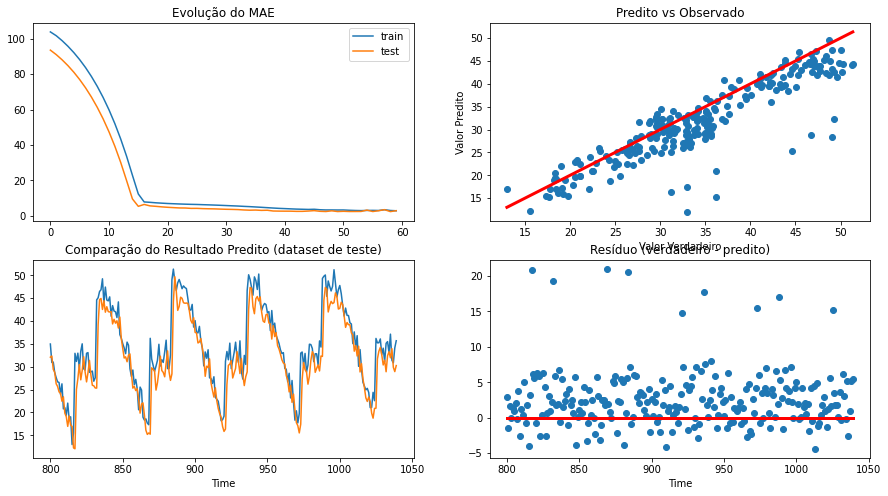

MAE: 2.871
RMSE: 4.825


In [69]:
def evaluate_history(history, test_set, x_valid):

    mae, loss = model.evaluate(test_set, verbose=0)

    plt.figure(figsize=(15,8))
    
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('Evolução do MAE')

    plt.subplot(2, 2, 3)
    forecast = []
    for time in range(split_time-window_size, len(series) - window_size):
        forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
    y_hat = np.array(forecast)[:, 0, 0]
    plt.plot(time_valid, x_valid, label='Valor Verdadeiro')
    plt.plot(time_valid, y_hat, label='Valor Predito')
    plt.xlabel('Time')
    plt.title('Comparação do Resultado Predito (dataset de teste)')

    plt.subplot(2, 2, 2)
    plt.plot(x_valid, y_hat, 'o')
    plt.plot([x_valid.min(), x_valid.max()], [x_valid.min(), x_valid.max()], 'r-', lw=3)
    plt.title('Predito vs Observado')
    plt.xlabel('Valor Verdadeiro')
    plt.ylabel('Valor Predito')

    plt.subplot(2, 2, 4)
    plt.plot(time_valid, x_valid - y_hat, 'o')
    plt.plot([time_valid.min(), time_valid.max()], [0, 0], 'r-', lw=3)
    plt.title('Resíduo (verdadeiro - predito)')
    plt.xlabel('Time')
    plt.show()  

    print('MAE: %.3f' % mae)

    rmse = np.sqrt(mean_squared_error(x_valid, y_hat))
    print('RMSE: %.3f' % rmse)


evaluate_history(history, test_set, x_valid)